In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import framework, models
from epam.torch_common import pick_device, parameter_count_of_model

/Users/matsen/mambaforge/envs/epam/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nicknames = ['59', '88', '97', 'small']

max_length=410
batch_size=1024
device = pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) #, sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)
    return train_dataset, val_dataset

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 100

In [4]:
def train_and_evaluate(model_name, model_instance, train_dataset, val_dataset):
    print(f"\tTraining {model_name}...")
    if "cnn" in model_name:
        train_dataset.to(device)
        val_dataset.to(device)
        model_instance.to(device)
    burrito = framework.Burrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
    
    train_history = burrito.train(epochs=epochs)
    # final_train_loss = burrito.process_data_loader(train_loader)
    best_val_loss = train_history['val_loss'].min()

    # Record pre-training and post-training losses
    result = {'model name': model_name, 'model': str(model_instance), 'parameter count': parameter_count_of_model(model_instance), 'val_loss': best_val_loss}
    return result

def comparison_of_data(model_instances, train_dataset, val_dataset):
    results_list = []

    for model_name, model_instance in model_instances.items():
        result = train_and_evaluate(model_name, model_instance, train_dataset, val_dataset)
        results_list.append(result)

    results_df = pd.DataFrame(results_list)
    return results_df

comparison_dfs = []
for nickname in val_nicknames:
    print(f"Val nickname is {nickname}")
    train_dataset_3, val_dataset_3 = data_of_nickname(nickname, kmer_length=3)
    train_dataset_5, val_dataset_5 = data_of_nickname(nickname, kmer_length=5)
    
    model_instances_3 = {
# hyperparameter optimization on 2023-11-23
# for model with <= 1024 parameters
# Best Hyperparameters: {'kernel_size': 7, 'dropout': 0.0, 'embedding_dim': 6, 'num_filters': 14}
# for model with <= 1524 parameters
# Best Hyperparameters: {'kernel_size': 11, 'dropout': 0.1, 'embedding_dim': 9, 'num_filters': 9}
# for model with <= 2048 parameters
# Best Hyperparameters: {'kernel_size': 11, 'dropout': 0.3, 'embedding_dim': 7, 'num_filters': 19}

        "cnn_sml": models.CNNModel(train_dataset_3, embedding_dim=6, num_filters=14, kernel_size=7, dropout_rate=0.0),
        "cnn_med": models.CNNModel(train_dataset_3, embedding_dim=9, num_filters=9, kernel_size=11, dropout_rate=0.1),
        "cnn_lrg": models.CNNModel(train_dataset_3, embedding_dim=7, num_filters=19, kernel_size=11, dropout_rate=0.3),
    }

    model_instances_5 = {
        "fivemer": models.FivemerModel(train_dataset_5),
        "shmoof": models.SHMoofModel(train_dataset_5),
    }
     
    comparison_df = \
        pd.concat([comparison_of_data(model_instances_3, train_dataset_3, val_dataset_3),
                    comparison_of_data(model_instances_5, train_dataset_5, val_dataset_5)])
    comparison_df["val_nickname"] = nickname

    # make val_nickname the first column
    cols = comparison_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    comparison_df = comparison_df[cols]

    comparison_dfs.append(comparison_df)

final_df = pd.concat(comparison_dfs)
final_df.to_csv(f"_ignore/model_comparison_{framework.timestamp_str()}.csv", index=False)
final_df
    

Val nickname is 59
	Training cnn_sml...


Epoch:  43%|████▎     | 43/100 [04:27<05:54,  6.22s/it, loss_diff=4.707e-07, lr=3.2e-5]  


	Training cnn_med...


Epoch:  37%|███▋      | 37/100 [04:28<07:37,  7.27s/it, loss_diff=8.472e-07, lr=3.2e-5]  


	Training cnn_lrg...


Epoch:  40%|████      | 40/100 [05:34<08:21,  8.37s/it, loss_diff=-1.148e-06, lr=3.2e-5] 


	Training fivemer...


Epoch:  33%|███▎      | 33/100 [00:30<01:02,  1.08it/s, loss_diff=1.577e-07, lr=3.2e-5]  


	Training shmoof...


Epoch:  43%|████▎     | 43/100 [00:40<00:53,  1.07it/s, loss_diff=6.424e-08, lr=3.2e-5]  


Val nickname is 88
	Training cnn_sml...


Epoch:  36%|███▌      | 36/100 [04:23<07:47,  7.31s/it, loss_diff=-1.697e-06, lr=3.2e-5] 


	Training cnn_med...


Epoch:  29%|██▉       | 29/100 [04:01<09:50,  8.32s/it, loss_diff=2.188e-06, lr=3.2e-5]  


	Training cnn_lrg...


Epoch:  30%|███       | 30/100 [04:18<10:03,  8.62s/it, loss_diff=3.409e-06, lr=3.2e-5]  


	Training fivemer...


Epoch:  32%|███▏      | 32/100 [00:30<01:04,  1.06it/s, loss_diff=1.963e-07, lr=3.2e-5]  


	Training shmoof...


Epoch:  35%|███▌      | 35/100 [00:33<01:02,  1.05it/s, loss_diff=3.492e-08, lr=3.2e-5]  


Val nickname is 97
	Training cnn_sml...


Epoch:  33%|███▎      | 33/100 [04:50<09:49,  8.80s/it, loss_diff=-7.065e-07, lr=3.2e-5] 


	Training cnn_med...


Epoch:  42%|████▏     | 42/100 [06:24<08:51,  9.16s/it, loss_diff=2.855e-07, lr=3.2e-5]  


	Training cnn_lrg...


Epoch:  40%|████      | 40/100 [06:07<09:10,  9.18s/it, loss_diff=-1.514e-06, lr=3.2e-5] 


	Training fivemer...


Epoch:  31%|███       | 31/100 [00:29<01:04,  1.06it/s, loss_diff=4.885e-08, lr=3.2e-5]  


	Training shmoof...


Epoch:  28%|██▊       | 28/100 [00:26<01:08,  1.05it/s, loss_diff=1.663e-08, lr=3.2e-5]  


Val nickname is small
	Training cnn_sml...


Epoch:  33%|███▎      | 33/100 [04:04<08:16,  7.41s/it, loss_diff=5.352e-07, lr=3.2e-5]  


	Training cnn_med...


Epoch:  29%|██▉       | 29/100 [04:04<09:58,  8.43s/it, loss_diff=-2.905e-07, lr=3.2e-5] 


	Training cnn_lrg...


Epoch:  34%|███▍      | 34/100 [04:41<09:07,  8.29s/it, loss_diff=-9.606e-07, lr=3.2e-5] 


	Training fivemer...


Epoch:  37%|███▋      | 37/100 [00:35<00:59,  1.05it/s, loss_diff=1.963e-08, lr=3.2e-5]  


	Training shmoof...


Epoch:  31%|███       | 31/100 [00:29<01:06,  1.04it/s, loss_diff=-1.065e-07, lr=3.2e-5] 


,val_nickname,model name,model,parameter count,val_loss
0,59,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.058132
1,59,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.058022
2,59,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.057902
0,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058234
1,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1435,0.058080
0,88,cnn_sml,"CNNModel(\n (kmer_embedding): Embedding(65, 6...",1007,0.050669
1,88,cnn_med,"CNNModel(\n (kmer_embedding): Embedding(65, 9...",1495,0.050384
2,88,cnn_lrg,"CNNModel(\n (kmer_embedding): Embedding(65, 7...",1957,0.050376
0,88,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.050709
1,88,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1435,0.050648


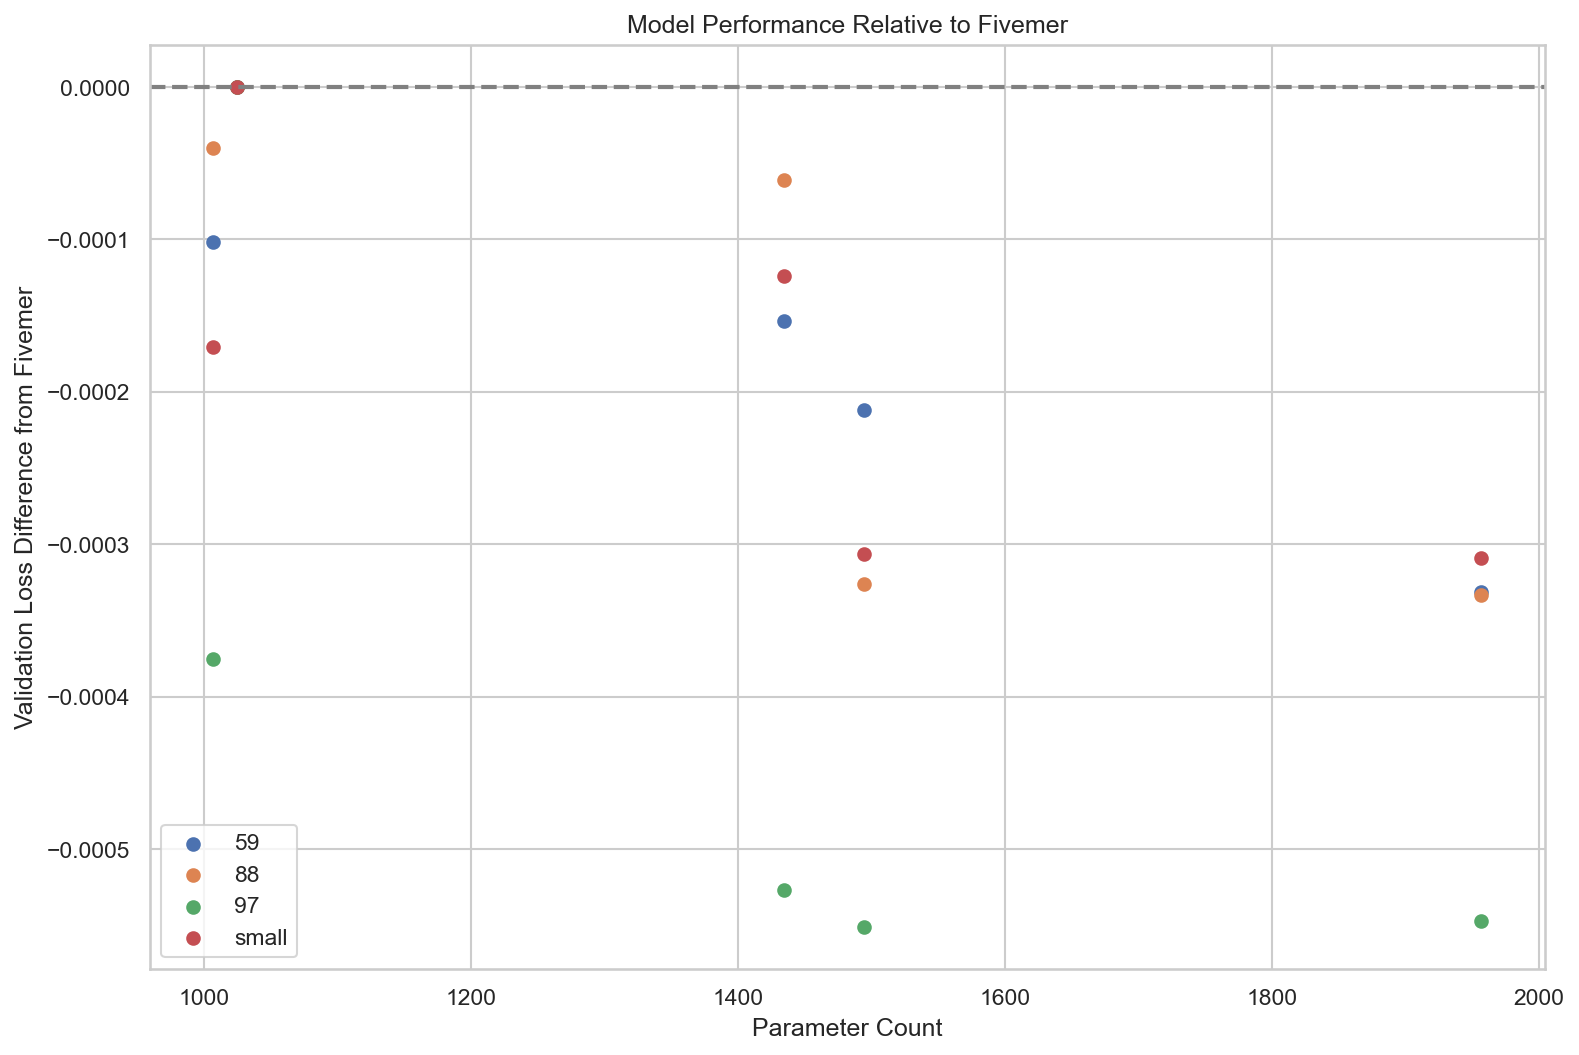

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df
# df = pd.read_csv("/Users/matsen/re/netam/notebooks/_ignore/model_comparison_20231122_072627.csv")

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            loss_diffs.append({'val_nickname': nickname, 'model': row['model name'], 'parameter_count': row['parameter count'], 'loss_diff': diff})

# Convert to DataFrame
loss_diff_df = pd.DataFrame(loss_diffs)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['parameter_count'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Parameter Count')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.legend()
plt.show()
